This notebook performs analysis on how model checkpoints learn to predict a variable across its percentile 


First, we need to look at the .nc files in the directory `/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data` and look at its structure.


 
- `var`: variable from ERA5 dataset to analyze
- `percentiles`: array of percentiles to analyze e.g. [90, 91, ..., 100]
- `grid_cell_latlon`: specific grid cell latitude and longitude to analyze percentiles

1. For the global ERA5 truth data of the variable `var`, compute the specified percentiles across the entire training period (1979-2015)
- the percentiles are defined as where the truth falls in or above the given percentile
- specifically we are computing which values of the variable `var` define the edges of each percentile bin

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import os
import json
from typing import List
import sys
sys.path.append('/projectnb/eb-general/wade/sfno/Example_Code/')
from utils import *
sys.path.append(".")  # Add current directory to Python path

In [27]:
# Grid cells for analyzing percentiles
grid_cell_latlon = [
    # (lat, lon)
    (34, -116+360),  # southwestern US, SoCal 
    (51.5, -0.75+360), # Northern Europe, London.  
]
var = "VAR_2T"
percentiles = np.arange(0,101)  # 0 to 100. 0th percentile -- minimum observed value. 100th percentile -- maximum observed value.


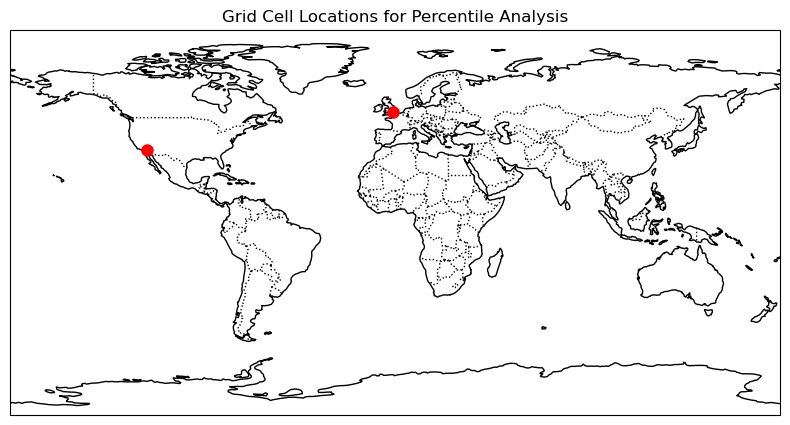

In [22]:
# plot the grid cell locations on a cartopy map

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()
for lat, lon in grid_cell_latlon:
    ax.plot(lon if lon <= 180 else lon - 360, lat, marker='o', color='red', markersize=8,
            transform=ccrs.PlateCarree())
plt.title('Grid Cell Locations for Percentile Analysis')
plt.show()


Get data for one grid cell across all time steps, and order the data, define the percentiles, then save the values at each percentile to a new .nc file.



In [6]:
six_hourly_dir = '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/'
file_names = [path for path in os.listdir(six_hourly_dir) if not os.path.isdir(path) and path.endswith('.nc')]
file_names.sort()
print(min(file_names), max(file_names))

# # filter files to start with 201001
# file_names = [f for f in file_names if f >= 'e5_2t_201001.nc']
# print(min(file_names), max(file_names))

e5_2t_197901.nc e5_2t_201512.nc


In [ ]:
fp = os.path.join(six_hourly_dir, file_names[0])

ds = xr.open_dataset(fp,engine="netcdf4")
ds

<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 1979-01-01 ... 1979-01-31T18:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper05 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon May 13 19:30:10 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon May 13 19:30:40 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)

In [ ]:
# loop through files, select the data for that month at the grid cell, and add to a time series array
plt.figure()
for lat,lon in grid_cell_latlon:
    time_series = []
    for file_name in file_names:
        fp = os.path.join(six_hourly_dir, file_name)
        ds = xr.open_dataset(fp,engine="netcdf4")
        data_point = ds[var].sel(latitude=lat, longitude=lon)
        month_data = data_point.values
        time_series.extend(month_data)
        ds.close()
    time_series = np.array(time_series)
    # compute percentiles
    pct_values = np.percentile(time_series, percentiles) # first axis of the result corresponds to the percentiles
    # plot for this grid cell, what the percentile values are
    
    plt.plot(percentiles, pct_values-273.15, 'o', label=f'lat {lat}, lon {lon}')

    # save the percentile values to a json file
    pct_dict = {str(p): float(v) for p, v in zip(percentiles, pct_values)}
    with open(f'percentiles/percentile_values/percentiles_{var}_lat{lat}_lon{lon}.json', 'w') as f:
        json.dump(pct_dict, f)
    print(f'Saved percentiles for lat {lat}, lon {lon} to json.')

plt.xlabel('Percentile')
plt.ylabel(f'{var} Value')
plt.title(f'Percentiles of {var} at grid cells based on 1979-2015 record')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'percentiles/figs/percentiles_{var}.png', dpi=300)
plt.close()
    

### Related code below


In [ ]:
# CODE FOR EXTRACTING 6-HOURLY DATA FROM 1-HOURLY DATASETS
for ind, f in enumerate(file_names):
    fp = os.path.join('/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data', f)
    ds = xr.open_dataset(fp,engine="netcdf4")

    # print(f)
    # print('t0', ds.isel(time=0).time.values, 't-1', ds.isel(time=-1).time.values, 'dt', np.diff(ds.time.values[:2])/np.timedelta64(1,'h'), ' hours')
    # print('datavars', list(ds.data_vars))
    # print('datadims', ds.dims)
    list(ds.data_vars).remove('utc_date')
    data_var_of_interest = list(ds.data_vars)[0]
    descrip = ds[data_var_of_interest].attrs
    # print(descrip)
    # print()

    # select only every 6 hourly timestamp, given that the data is stored in ds.time and the ds.time array has dtype='datetime64[ns]'
    hours = ds.time.dt.hour
    # time snapshots at 0000, 0600, 1200, 1800, UTC so where hours is 0, 6, 12, or 18
    mask = (hours == 0) | (hours == 6) | (hours == 12) | (hours == 18)
    # print(mask)
    six_hourly_times = ds.time.where(mask, drop=True)
    # print('six_hourly_times', six_hourly_times.values, 'dt', np.diff(six_hourly_times.values[:2])/np.timedelta64(1,'h'), ' hours')
    ds_6hourly = ds.sel(time=six_hourly_times)
    if ind % 100 == 0:
        print(ds_6hourly)
    
    # save to the six_hourly_dir
    ds_6hourly.to_netcdf(os.path.join(six_hourly_dir, f))
    

<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 2010-01-01 ... 2010-01-31T18:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r6i3n31 4.12.14-94.41-default #1 SMP Wed Oct ...
    CONVERSION_DATE:      Mon Aug 19 17:06:58 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Aug 19 17:07:15 2019: ncks -4 --ppc default=7 e...
    NCO:      

/projectnb/eb-general/wade/.conda/envs/dl/lib/python3.12/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [12]:
# CODE FOR LOADING SFNO DATA FROM ERA5 FOR A GIVEN TIMESTEP RANGE
# steps are 6-hourly (e.g. 12 steps = 3 days)
n_steps = 12

# Open and load the JSON file
SFNO_dir = '/projectnb/eb-general/shared_data/data/processed/sfno/'
data_fp = os.path.join(SFNO_dir,'ERA5_SFNO','data.json')

# open initial conditions from stored ERA data
later_str = (datetime.fromisoformat(timestep_select) + timedelta(hours = n_steps*6)).isoformat() 
print(f"Selecting timestep {timestep_select} to {later_str}")

with open(data_fp, 'r') as f:
    labels = json.load(f)

# open initial conditions from stored ERA data
timestep_select = '2021-06-27T00:00:00'
year_of_timestep = datetime.fromisoformat(timestep_select).year
data_create = open_hdf5(path = os.path.join(SFNO_dir, 'ERA5_SFNO',str(year_of_timestep)+'.h5'), metadata = labels)
data_create = data_create.sel(time = [timestep_select, later_str]) # this just selects the first and last time in the time range
data_create = data_create.rename({"channel": "variable"})
data_create


NameError: name 'timestep_select' is not defined

In [4]:
# open testing data (file of a whole year of data formatted for the sfno model) 
# at /projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5
ds = xr.open_dataset('/projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5', engine='h5netcdf')
print(ds)

/scratch/375941.1.ood/ipykernel_826948/2635312399.py:2: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  ds = xr.open_dataset('/projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5', engine='h5netcdf')


<xarray.Dataset> Size: 449GB
Dimensions:  (phony_dim_0: 1460, phony_dim_1: 74, phony_dim_2: 721,
              phony_dim_3: 1440)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3
Data variables:
    fields   (phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3) float32 449GB ...
